### Introduction to Stock Analysis

In this notebook you will find the basic steps to start an stock analysis:

- How to have acess to share's data
- Which share price to use and why;
- Plot a time series of your data;

Let's get rich?

In [2]:
# inviting our friends to the party:
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, isnan
from pylab import *
from matplotlib import style
from scipy.signal import find_peaks

from sklearn.cluster import KMeans

%matplotlib inline

In [3]:
!pip install yfinance
import yfinance as yf


In [45]:
start = "2014-01-01"
end = '2019-1-01'
tsla = yf.download('TSLA',start,end)

[*********************100%%**********************]  1 of 1 completed


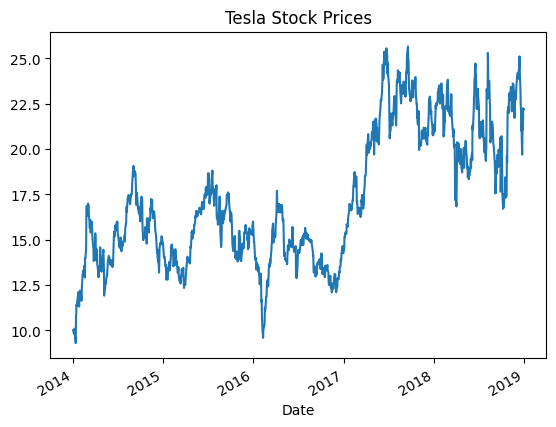

In [46]:
tsla['Close'].plot()
plt.title("Tesla Stock Prices")
plt.show()

In [47]:
# Now let's define a range, that means, from when until when we want the data:
start_date= datetime.datetime(2005, 1, 1) # the format is YYYY-MM-DD
end_date= datetime.datetime(2019, 12, 31)

In [48]:
# We will use data from Google and Microsoft in our analysis
google = yf.download('GOOG', start_date, end_date)
microsoft= yf.download('MSFT', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [49]:
google.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,4.916571,5.071989,4.868253,5.048826,5.048826,636143518
2005-01-04,5.016198,5.054305,4.818937,4.844342,4.844342,552298420


In [50]:
microsoft.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,26.799999,26.950001,26.65,26.74,18.660545,65002900
2005-01-04,26.870001,27.100000,26.66,26.84,18.730337,109442100


You may have noted that we have different columns here. We are interested in comparing the closing prices during the period we selected. We will use the Adjusted Close price, as it represents a more accurate way to measure a stock price, as it takes into account factors like dividends and stock splits.

Source: https://budgeting.thenest.com/adjusted-closing-price-vs-closing-price-32457.html

In [51]:
# deleting all columns and keeping just the date and adjusted close price
goog_close= google.drop(google.columns[0:5], axis=1)
msft_close= microsoft.drop(microsoft.columns[0:5], axis=1)

In [52]:
def _get_all_indexes_above_threshold(signal, moving_average, beta):
    all_peaks = []
    all_valleys = []
    for idx, val in enumerate(signal):
        diff = val / moving_average[idx] - 1
        if diff > beta:
            all_peaks.append(idx)
        elif diff < -beta:
            all_valleys.append(idx)
    return all_peaks, all_valleys

df = tsla.copy()
df['SMA30_High'] = df['High'].rolling(30).mean()
# offset backpopulate the moving average
df['SMA30_High'] = df['SMA30_High'].shift(-15)

df['SMA30_Low'] = df['Low'].rolling(30).mean()
# offset backpopulate the moving average
df['SMA30_Low'] = df['SMA30_Low'].shift(-15)


# Input signal
t = np.arange(df.shape[0])


# Find indices of peaks
#peak_idx, _ = find_peaks(series, height=thresh)
peak_idx, _ = find_peaks(df['High'], height=11)

# Eliminate peaks under a moving average threshold at time t

# Find indices of valleys (from inverting the signal)
#valley_idx, _ = find_peaks(-df['Close'], height=thresh)
#print( peak_idx )
#print(df['SMA30_High'])
mask = df.index.isin(peak_idx)
filtered_df = df.iloc[peak_idx]
print( filtered_df.shape )

best_peaks, all_valleys = _get_all_indexes_above_threshold(df['High'], df['SMA30_High'], 0.075)
all_peaks, best_valleys = _get_all_indexes_above_threshold(df['Low'], df['SMA30_Low'], 0.075)

(287, 8)


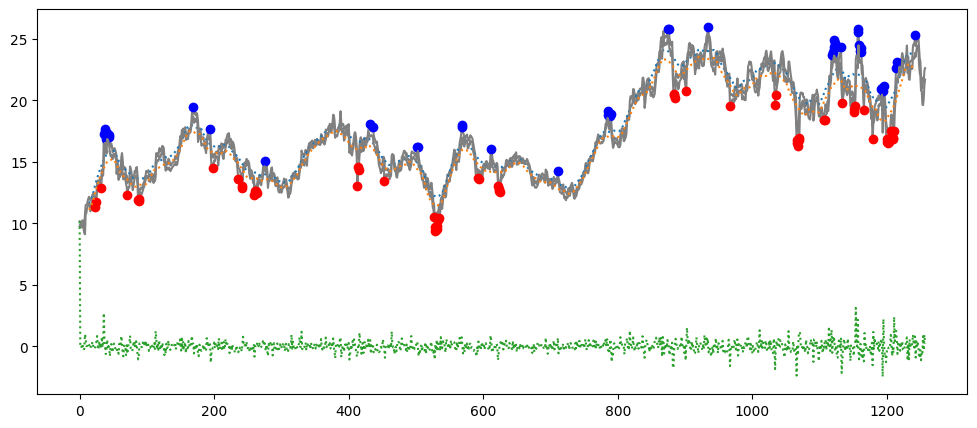

In [53]:
#     ___ detection of local minimums and maximums ___
# The min and max outlier values from the offset moving average represent distinct support and resistance
# We discover these dependant values and will use these in supervised learning to find in other ways not dependant on values
#
data = tsla['High']
a = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1               # local min & max
b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1         # local max
d = np.diff(data, prepend=[0])
# +1 due to the fact that diff reduces the original index number

# plot
plt.figure(figsize=(12, 5))
plt.plot(t, data, color='grey')
#plt.plot(t[b], data[b], "o", label="min", color='r')
plt.plot(t[best_peaks], data[best_peaks], "o", label="max", color='b')
plt.plot(t, df['SMA30_High'], linestyle = 'dotted')

data = tsla['Low']
a = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1               # local min & max
b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1         # local max
# +1 due to the fact that diff reduces the original index number

plt.plot(t, data, color='grey')
plt.plot(t[best_valleys], data[best_valleys], "o", label="max", color='r')
plt.plot(t, df['SMA30_Low'], linestyle = 'dotted')
plt.plot(t, d, linestyle = 'dotted')

plt.show()

In [54]:
# A secondary method of preparing dependant data is analyzing the line simplifications of notable mins and maxes
def douglas_peucker(points, epsilon):
    """Douglas-Peucker line simplification algorithm.

    Args:
    - points: List of (x, y) tuples representing the points of the line.
    - epsilon: Tolerance parameter specifying the maximum distance allowed between the original line
               and the simplified line.

    Returns:
    - List of indices of the points that are kept in the simplified line.
    """
    # Find the point with the maximum distance
    dmax = 0
    index = 0
    end = len(points) - 1
    for i in range(1, end):
        d = perpendicular_distance(points[i], points[0], points[end])
        if d > dmax:
            index = i
            dmax = d

    # If max distance is greater than epsilon, recursively simplify both sublines
    indices = []
    if dmax > epsilon:
        indices_before = douglas_peucker(points[:index + 1], epsilon)
        indices_after = douglas_peucker(points[index:], epsilon)
        indices = indices_before[:-1] + indices_after  # Exclude the duplicate index
    else:
        # If max distance is not greater than epsilon, keep the endpoints
        indices = [points[0], points[end]]

    return indices

def perpendicular_distance(point, start, end):
    """Calculate the perpendicular distance between a point and a line segment."""
    x0, y0 = point
    x1, y1 = start
    x2, y2 = end
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    return numerator / denominator

In [55]:
data_high = df['High']
data_low = df['Low']

# Set the tolerance parameter epsilon
epsilon = 1.85  # Maximum perpendicular distance threshold
a = (np.diff(np.sign(np.diff(data_high))) < 0).nonzero()[0] + 1         # local max
points = [(i, data_high[i]) for i in range(0, df.shape[0])]
simplified_points = douglas_peucker(points, epsilon)
simplified_high_indices = [point[0] for point in simplified_points]
simplified_high_indices = [x for x in a if x in simplified_high_indices]

epsilon = 1.85  # Maximum perpendicular distance threshold
b = (np.diff(np.sign(np.diff(data_low))) > 0).nonzero()[0] + 1         # local min
points = [(i, data_low[i]) for i in range(0, df.shape[0])]
simplified_points = douglas_peucker(points, epsilon)
simplified_low_indices = [point[0] for point in simplified_points]
simplified_low_indices = [x for x in b if x in simplified_low_indices]

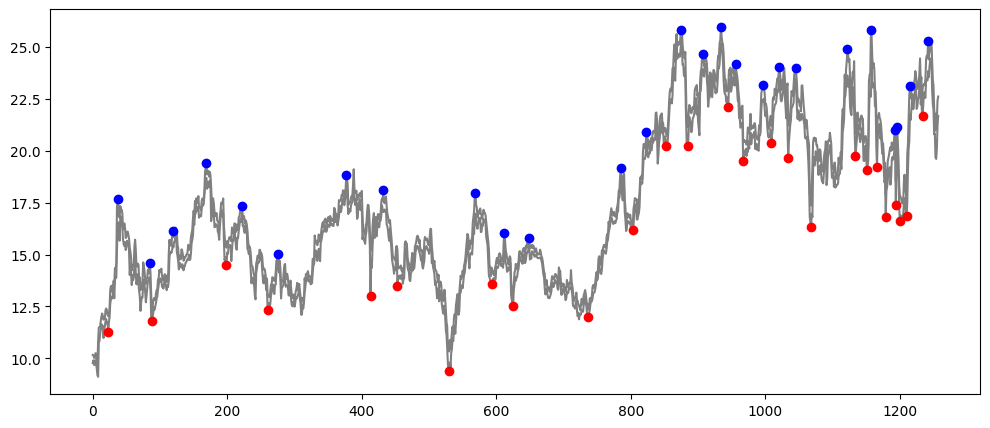

In [56]:
plt.figure(figsize=(12, 5))
plt.plot(t, data_low, color='grey')
plt.plot(t, data_high, color='grey')
plt.plot(t[simplified_high_indices], data_high[simplified_high_indices], "o", label="max", color='b')
plt.plot(t[simplified_low_indices], data_low[simplified_low_indices], "o", label="min", color='r')

plt.show()

## Find the cluster centroid(s) of the blue and red dots
- We want to find the major and minor stock price resistances
- We want to find the major and minor stock price support
- Note that the market makes a shift so a new set of support and resistance should also be found.

Date
2014-01-02    10.165333
2014-01-03    10.146000
2014-01-06    10.026667
2014-01-07    10.026667
2014-01-08    10.246667
                ...    
2018-12-24    20.966667
2018-12-26    21.798000
2018-12-27    21.478001
2018-12-28    22.416000
2018-12-31    22.614000
Name: High, Length: 1258, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

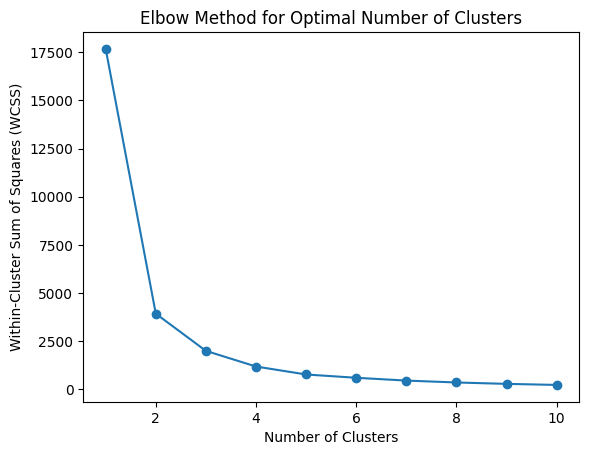

In [57]:
# Standardize the data
print(data_high)
#stock_prices_standardized = (data_high - data_high.mean(axis=0)) / data_high.std(axis=0)
#stock_prices_standardized = data_high

# Transpose the array so that each row represents a single sample (company)
stock_prices_standardized = data_high.values.reshape(-1, 1)
# Determine the optimal number of clusters using the elbow method
wcss = []
max_clusters = 10  # Maximum number of clusters to try
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(stock_prices_standardized)
    wcss.append(kmeans.inertia_)

data_high['Cluster'] = kmeans.labels_

# Plot the within-cluster sum of squares (WCSS) against the number of clusters
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Work In Progress...

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster centroids:
Cluster 1: [22.01429816]
Cluster 2: [15.10025012]


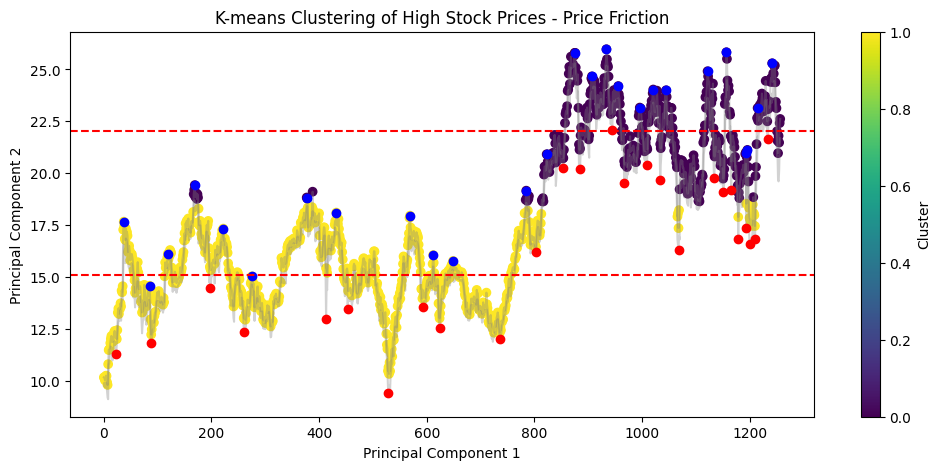

In [63]:
# Choose the optimal number of clusters based on the elbow method (e.g., visually inspect the plot)
optimal_num_clusters = 2  # Hard coded for now, but looking for best way to programmatically determine

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', random_state=42)
kmeans.fit(stock_prices_standardized)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

plt.figure(figsize=(12, 5))
plt.plot(t, df['Low'], alpha=0.35, color='grey')
plt.plot(t, df['High'], alpha=0.35, color='grey')
plt.plot(t[simplified_high_indices], data_high[simplified_high_indices], "o", label="max", color='b')
plt.plot(t[simplified_low_indices], data_low[simplified_low_indices], "o", label="min", color='r')



# Visualize the clusters (for demonstration purposes, plot only the first two principal components)
plt.scatter(range(0, len(stock_prices_standardized)), stock_prices_standardized[:, 0], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of High Stock Prices - Price Friction')
plt.colorbar(label='Cluster')



# Get cluster centroids
centroids = kmeans.cluster_centers_

# Print centroids
print("Cluster centroids:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i+1}: {centroid}")
    plt.axhline(y=centroid, color='r', linestyle='--')
plt.show()